### Packages utlisés

In [1]:
import pandas as pd
import re
import string
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import bigrams
import spacy
from itertools import combinations
import json



import spacy
import spacy.cli

from pathlib import Path

import torch
from transformers import (
    TextClassificationPipeline, 
    AutoModelForSequenceClassification, 
    AutoTokenizer
)

c:\Users\kadas\Desktop\Mes_cours\FINANCE_QUAN\Projet_finance_quantitative\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Optionnel pour WordNet Lemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kadas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kadas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kadas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\kadas\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Chargement des données 

In [3]:
# Dossier principal pour les données
DATA_DIR = Path.cwd().parent / "data"
ARTICLES_DIR = DATA_DIR / "raw"
POSTS_DIR = DATA_DIR / "reddit_data"

# Liste des cryptomonnaies à analyser
cryptos = [
    "binance_coin", "bitcoin", "cardano", "dogecoin", "ethereum",
    "solana", "tether", "xrp", "litecoin", "shiba_inu", "tron"
]

# Boucle pour charger les fichiers d'articles et de posts
for crypto in cryptos:
    try:
        # Chemins des fichiers CSV pour chaque cryptomonnaie
        articles_path = ARTICLES_DIR / f"articles_{crypto}.csv"
        posts_path = POSTS_DIR / f"{crypto}_posts.csv"

        # Chargement des fichiers dans des DataFrames pandas
        articles = pd.read_csv(articles_path)
        posts = pd.read_csv(posts_path)

        # Informations sur la taille des fichiers
        print(f"{crypto.capitalize()} : Articles ({articles.shape[0]} lignes, {articles.shape[1]} colonnes), "
              f"Posts ({posts.shape[0]} lignes, {posts.shape[1]} colonnes)")
    except FileNotFoundError as e:
        # Message d'alerte en cas de fichier manquant
        print(f"⚠️ Fichier introuvable pour {crypto} : {e}")

Binance_coin : Articles (1189 lignes, 3 colonnes), Posts (109 lignes, 7 colonnes)
Bitcoin : Articles (1049 lignes, 3 colonnes), Posts (494 lignes, 7 colonnes)
Cardano : Articles (902 lignes, 3 colonnes), Posts (375 lignes, 7 colonnes)
Dogecoin : Articles (1363 lignes, 3 colonnes), Posts (318 lignes, 7 colonnes)
Ethereum : Articles (3054 lignes, 3 colonnes), Posts (489 lignes, 7 colonnes)
Solana : Articles (2672 lignes, 3 colonnes), Posts (365 lignes, 7 colonnes)
Tether : Articles (529 lignes, 3 colonnes), Posts (173 lignes, 7 colonnes)
Xrp : Articles (1653 lignes, 3 colonnes), Posts (376 lignes, 7 colonnes)
Litecoin : Articles (138 lignes, 3 colonnes), Posts (306 lignes, 7 colonnes)
Shiba_inu : Articles (1168 lignes, 3 colonnes), Posts (272 lignes, 7 colonnes)
Tron : Articles (3032 lignes, 3 colonnes), Posts (290 lignes, 7 colonnes)


#### Vérification des news sans date renseignée

In [4]:
# Dossiers contenant les données
DATA_DIR = Path.cwd().parent / "data"
ARTICLES_DIR = DATA_DIR / "raw"
POSTS_DIR = DATA_DIR / "reddit_data"

# Liste des cryptomonnaies à analyser
cryptos = [
    "binance_coin", "bitcoin", "cardano", "dogecoin", "ethereum",
    "solana", "tether", "xrp", "litecoin", "shiba_inu", "tron"
]

# Chargement des données pour une crypto choisie (exemple avec "bitcoin")
crypto = "bitcoin"
articles_path = ARTICLES_DIR / f"articles_{crypto}.csv"
posts_path = POSTS_DIR / f"{crypto}_posts.csv"

articles = pd.read_csv(articles_path)
posts = pd.read_csv(posts_path)

print(f"{crypto.capitalize()} - Colonnes des articles :")
print(articles.columns, "\n")
print(f"{crypto.capitalize()} - Colonnes des posts :")
print(posts.columns, "\n")

Bitcoin - Colonnes des articles :
Index(['title', 'date', 'description'], dtype='object') 

Bitcoin - Colonnes des posts :
Index(['crypto', 'subreddit', 'title', 'score', 'comments', 'created', 'url'], dtype='object') 



In [5]:
# Harmonisation des données pour les articles et les posts
# On  conserve les colonnes nécessaires dans les articles
articles = articles[['date', 'title', 'description']]  # Garder uniquement les colonnes essentielles

posts = posts.rename(columns={'created': 'date'})  # Ici, l'on renomme la colonne "created" en "date"
posts['description'] = posts['title']  # On copie le contenu de "title" des posts Reddit dans une colonne "description"
posts = posts[['date', 'title', 'description']]  # Et l'on garde finalement uniquement les colonnes essentielles

print("Articles (après traitement) :")
print(articles.head(), "\n")
print("Posts (après traitement) :")
print(posts.head(), "\n")

Articles (après traitement) :
                  date                                              title  \
0  2025-02-08 13:28:00  Arizona lawmakers push bill to curb Bitcoin AT...   
1  2025-02-08 08:25:00  Bitcoin price forms rare patterns: a surge to ...   
2  2025-02-08 08:20:00  Here’s why Russia’s investigating committee se...   
3  2025-02-07 21:23:00  Bybit: Bitcoin held its ground, altcoins saw r...   
4  2025-02-07 21:10:00  Missouri introduces bill to establish Bitcoin ...   

                                         description  
0  A new Arizona bill aims to protect residents f...  
1  Bitcoin price remained under pressure this wee...  
2  Russia’s main federal investigating authority ...  
3  Bitcoin remained resilient during the latest m...  
4  Missouri is joining the trend of states embrac...   

Posts (après traitement) :
                  date                                              title  \
0  2025-02-08 18:23:08    Bitcoin (BTC) Holders VS Ethereum (ETH) Holde

In [6]:
# Valeurs uniques de la colonne "date" dans les articles
unique_dates_articles = articles['date'].unique()
print("Valeurs uniques de 'date' dans les articles :")
print(unique_dates_articles)

# ... dans les posts
unique_dates_posts = posts['date'].unique()
print("\nValeurs uniques de 'date' dans les posts :")
print(unique_dates_posts)

Valeurs uniques de 'date' dans les articles :
['2025-02-08 13:28:00' '2025-02-08 08:25:00' '2025-02-08 08:20:00' ...
 '2024-08-13 09:55:00' '2024-08-13 08:58:00' '2024-08-13 08:17:00']

Valeurs uniques de 'date' dans les posts :
['2025-02-08 18:23:08' '2025-02-08 21:44:01' '2025-02-08 14:54:31'
 '2025-02-08 17:11:26' '2025-02-08 22:05:44' '2025-02-08 15:39:29'
 '2025-02-07 18:41:43' '2025-02-07 19:00:56' '2025-02-08 04:15:47'
 '2025-02-08 11:56:38' '2025-02-06 18:17:31' '2025-02-05 20:02:36'
 '2025-02-07 14:45:39' '2025-02-08 10:20:09' '2025-02-08 19:08:12'
 '2025-02-07 11:56:02' '2025-02-07 21:24:03' '2025-02-08 09:37:51'
 '2025-02-07 02:08:13' '2025-02-06 14:48:01' '2025-02-06 20:56:08'
 '2025-02-07 08:26:36' '2025-02-06 12:44:06' '2025-02-05 21:32:25'
 '2025-02-05 19:57:19' '2025-02-06 09:08:42' '2025-02-06 23:27:20'
 '2025-02-05 23:50:44' '2025-02-05 17:09:49' '2025-02-05 17:12:29'
 '2025-02-05 17:09:33' '2025-02-05 06:00:56' '2025-02-05 17:23:56'
 '2025-02-05 05:17:40' '2025-02-08

In [7]:
# Une structure pour stocker les DataFrames des articles et des posts
crypto_articles_dfs = {}
crypto_posts_dfs = {}

# Une boucle pour charger les fichiers CSV d'articles et de posts
for crypto in cryptos:
    try:
        articles_path = ARTICLES_DIR / f"articles_{crypto}.csv"
        posts_path = POSTS_DIR / f"{crypto}_posts.csv"

        articles = pd.read_csv(articles_path)
        posts = pd.read_csv(posts_path)

        # Ajout des DataFrames dans les dictionnaires
        crypto_articles_dfs[crypto] = articles
        crypto_posts_dfs[crypto] = posts

        print(f"{crypto.capitalize()} : Articles ({articles})")
        print(f"{crypto.capitalize()} : Posts ({posts})")
    except FileNotFoundError as e:
        # Message d'alerte en cas de fichier manquant
        print(f"⚠️ Fichier introuvable pour {crypto} : {e}")

Binance_coin : Articles (                                                  title                 date  \
0     Binance coin’s strong year falters as 1Fuel dr...  2025-02-05 13:47:00   
1     Cryptos to watch in 2025: Rollblock, Cardano, ...  2025-01-23 20:55:00   
2     Remittix could outperform Shiba Inu, Cardano a...  2025-01-23 13:02:00   
3     Binance Coin drops despite flipping Ethereum i...  2025-01-20 17:45:00   
4     Why this crypto could outshine Binance Coin an...  2025-01-16 09:50:00   
...                                                 ...                  ...   
1184                                            Cardano              Inconnu   
1185                                             Tether              Inconnu   
1186                                           Ethereum              Inconnu   
1187                                         Buy Crypto              Inconnu   
1188          OKX: A Crypto-to-Crypto and Fiat Exchange              Inconnu   

              

In [8]:
# Les colonnes des articles sont adaptées pour inclure uniquement ce qui est nécessaire
for crypto, articles_df in crypto_articles_dfs.items():
    crypto_articles_dfs[crypto] = articles_df[['date', 'title', 'description']].fillna("Inconnu")

# Les colonnes des posts suivent la même structure que celles des articles
for crypto, posts_df in crypto_posts_dfs.items():
    posts_df = posts_df.rename(columns={"created": "date"})  # Une nouvelle colonne "date" à partir de "created"
    posts_df["description"] = posts_df["title"]  # Le titre est copié dans une colonne appelée "description"
    crypto_posts_dfs[crypto] = posts_df[['date', 'title', 'description']].fillna("Inconnu")

In [9]:
# Une structure pour regrouper les données fusionnées de chaque cryptomonnaie
merged_crypto_dfs = {}

# Les articles et posts sont combinés pour chaque crypto dans un seul DataFrame
for crypto, articles_df in crypto_articles_dfs.items():
    posts_df = crypto_posts_dfs.get(crypto)  # Les posts correspondants sont récupérés
    if articles_df is not None and posts_df is not None:
        merged_df = pd.concat([articles_df, posts_df], ignore_index=True)  # Une fusion des deux DataFrames
        merged_crypto_dfs[crypto] = merged_df
        print(f"{crypto.capitalize()} : Fusion réussie avec {len(merged_df)} lignes.")
    else:
        print(f"{crypto.capitalize()} : Les articles ou posts sont manquants.")

Binance_coin : Fusion réussie avec 1298 lignes.
Bitcoin : Fusion réussie avec 1543 lignes.
Cardano : Fusion réussie avec 1277 lignes.
Dogecoin : Fusion réussie avec 1681 lignes.
Ethereum : Fusion réussie avec 3543 lignes.
Solana : Fusion réussie avec 3037 lignes.
Tether : Fusion réussie avec 702 lignes.
Xrp : Fusion réussie avec 2029 lignes.
Litecoin : Fusion réussie avec 444 lignes.
Shiba_inu : Fusion réussie avec 1440 lignes.
Tron : Fusion réussie avec 3322 lignes.


In [10]:
# Une étape pour combiner tous les DataFrames fusionnés en un seul DataFrame final
df_crypto = pd.concat(
    [df for df in merged_crypto_dfs.values()],
    ignore_index=True  # Les index des lignes sont réinitialisés pour unifier les données
)

print(f"DataFrame final créé avec {df_crypto.shape[0]} lignes et {df_crypto.shape[1]} colonnes.")
print(df_crypto.head())

DataFrame final créé avec 20316 lignes et 3 colonnes.
                  date                                              title  \
0  2025-02-05 13:47:00  Binance coin’s strong year falters as 1Fuel dr...   
1  2025-01-23 20:55:00  Cryptos to watch in 2025: Rollblock, Cardano, ...   
2  2025-01-23 13:02:00  Remittix could outperform Shiba Inu, Cardano a...   
3  2025-01-20 17:45:00  Binance Coin drops despite flipping Ethereum i...   
4  2025-01-16 09:50:00  Why this crypto could outshine Binance Coin an...   

                                         description  
0  Binance coin drops 17% in a month as investors...  
1  Not all fast-growing crypto tokens are good in...  
2  Remittix is making waves in the crypto industr...  
3  Binance Coin price remained in a tight range o...  
4  As the crypto market gears up for its next bul...  


In [11]:
# Les lignes où la date est "Inconnu" sont retirées pour garantir des données exploitables
df_crypto = df_crypto[df_crypto['date'] != "Inconnu"]

print(f"DataFrame final après suppression des 'Inconnu' : {df_crypto.shape[0]} lignes restantes.")

DataFrame final après suppression des 'Inconnu' : 20177 lignes restantes.


#### Fusion des bases de données sur les différentes cryptomonnaies

In [12]:
print(f"Shape de df_crypto : {df_crypto.shape}")

Shape de df_crypto : (20177, 3)


In [13]:
def clean_dataframe(df):
    # Les lignes où la date est "Inconnu" (en tenant compte des majuscules/minuscules) ou NaN sont supprimées
    df = df[df["date"].astype(str).str.lower() != "inconnu"]

    # Les descriptions vides ou manquantes sont également retirées
    df = df.dropna(subset=["description"])  
    df = df[df["description"].str.strip() != ""]  

    # Réinitialisation de l'index pour garantir un index continu après nettoyage
    return df.reset_index(drop=True)

# Nettoyage du DataFrame en appliquant la fonction définie
df_crypto = clean_dataframe(df_crypto)

In [14]:
clean_dataframe(df_crypto)

,date,title,description
0,2025-02-05 13:47:00,Binance coin’s strong year falters as 1Fuel dr...,Binance coin drops 17% in a month as investors...
1,2025-01-23 20:55:00,"Cryptos to watch in 2025: Rollblock, Cardano, ...",Not all fast-growing crypto tokens are good in...
2,2025-01-23 13:02:00,"Remittix could outperform Shiba Inu, Cardano a...",Remittix is making waves in the crypto industr...
3,2025-01-20 17:45:00,Binance Coin drops despite flipping Ethereum i...,Binance Coin price remained in a tight range o...
4,2025-01-16 09:50:00,Why this crypto could outshine Binance Coin an...,As the crypto market gears up for its next bul...
...,...,...,...
20172,2024-03-04 20:54:38,The last time BTC was above $67K was Nov. 10th...,The last time BTC was above $67K was Nov. 10th...
20173,2024-02-22 01:11:27,Tether won’t confirm or deny if it’s dropping ...,Tether won’t confirm or deny if it’s dropping ...
20174,2024-02-26 13:02:47,"$1k into the Top 10 Cryptos on January 1st, 20...","$1k into the Top 10 Cryptos on January 1st, 20..."
20175,2024-02-21 05:34:48,USDC Stablecoin’s Issuer Circle Dumps Tron Net...,USDC Stablecoin’s Issuer Circle Dumps Tron Net...


#### Suppresion de certaines lignes (valeurs manquantes) 

#### Création de la colonne "cryptocurrency"

In [14]:
# Un dictionnaire pour mapper les noms des cryptos avec leurs abréviations officielles
crypto_mapping = {
    "Bitcoin": "BTC",
    "Ethereum": "ETH",
    "BNB": "BNB",
    "Solana": "SOL",
    "Cardano": "ADA",
    "Dogecoin": "DOGE",
    "Shiba_inu": "SHIB",
    "Litecoin": "LTC",
    "Tether": "USDT",
    "XRP": "XRP",
    "Tron": "TRX"
}

# Fonction pour détecter une crypto dans une chaîne de texte
def find_primary_crypto(text):
    # Vérification si le texte est NaN ou non
    if pd.isna(text):
        return None

    # Conversion du texte en string pour éviter les erreurs
    text = str(text)

    # Recherche de correspondances dans le texte en utilisant les clés du mapping
    for key, value in crypto_mapping.items():
        pattern = rf"\b{re.escape(key)}\b"  # Recherche du mot complet (sensibilité à l'espacement)
        if re.search(pattern, text, re.IGNORECASE):  # Recherche insensible à la casse
            return value  

    # Retourne None si aucune correspondance n'est trouvée
    return None

# Fonction principale : recherche dans la description, puis dans le titre si nécessaire
def detect_crypto(row):
    # Recherche prioritairement dans la description
    primary_crypto = find_primary_crypto(row["description"])

    # Si aucune crypto trouvée, recherche dans le titre
    if primary_crypto is None:
        primary_crypto = find_primary_crypto(row["title"])

    # Retourne le nom de la crypto trouvé ou None
    return primary_crypto

# Création de la colonne "cryptocurrency" en appliquant la fonction sur chaque ligne
df_crypto["cryptocurrency"] = df_crypto.apply(detect_crypto, axis=1)

In [15]:
print(df_crypto.head())

                  date                                              title  \
0  2025-02-05 13:47:00  Binance coin’s strong year falters as 1Fuel dr...   
1  2025-01-23 20:55:00  Cryptos to watch in 2025: Rollblock, Cardano, ...   
2  2025-01-23 13:02:00  Remittix could outperform Shiba Inu, Cardano a...   
3  2025-01-20 17:45:00  Binance Coin drops despite flipping Ethereum i...   
4  2025-01-16 09:50:00  Why this crypto could outshine Binance Coin an...   

                                         description cryptocurrency  
0  Binance coin drops 17% in a month as investors...            XRP  
1  Not all fast-growing crypto tokens are good in...            ADA  
2  Remittix is making waves in the crypto industr...            ADA  
3  Binance Coin price remained in a tight range o...            ETH  
4  As the crypto market gears up for its next bul...            XRP  


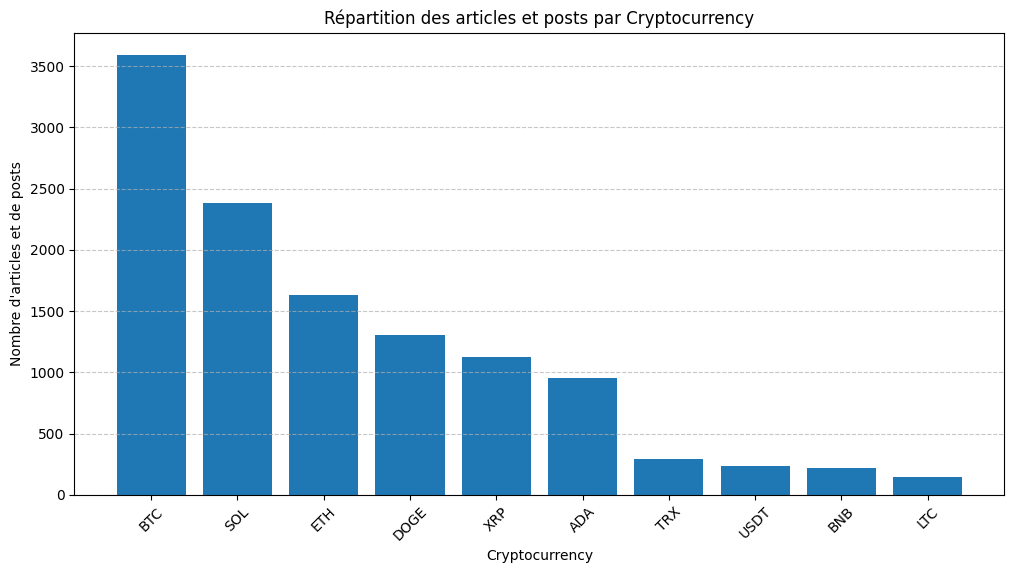

In [16]:
# Le comptage des occurrences de chaque crypto pour analyser leur répartition
crypto_counts = df_crypto["cryptocurrency"].value_counts()

plt.figure(figsize=(12, 6))  
plt.bar(crypto_counts.index, crypto_counts.values) 
plt.xlabel("Cryptocurrency")  
plt.ylabel("Nombre d'articles et de posts")  
plt.title("Répartition des articles et posts par Cryptocurrency")  
plt.xticks(rotation=45) 
plt.grid(axis='y', linestyle='--', alpha=0.7)  

plt.show()

### Preprocessing des données textuelles

In [17]:
# Une installation et un chargement du modèle Spacy pour le traitement de texte en anglais
spacy.cli.download("en_core_web_sm") 
nlp = spacy.load("en_core_web_sm")  # Charger le modèle pour l'analyse linguistique

# Une liste personnalisée de mots à ignorer, incluant des termes spécifiques au contexte crypto
custom_stop_words = [
    "http", "https", "www", "coin", "crypto", "cryptocurrency", "bitcoin", "btc",
    "ethereum", "eth", "blockchain", "today", "tonight", "actually", "lol",
    "day", "hour", "minute", "sec", "talk", "price", "market", "coin"
]

# Une fonction dédiée au nettoyage et au prétraitement des textes
def crypto_text_preprocessing(text):
    # Les URL, mentions et hashtags sont supprimés pour réduire le bruit dans les données
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'[@#]\w+', '', text)

    # Les balises HTML, souvent inutiles, sont également supprimées
    text = re.sub(r'<.*?>', '', text)

    # On se concentre uniquement sur les caractères alphanumériques
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    text = text.lower()  # Une conversion en minuscules pour uniformiser le texte

    # Une tokenisation avec Spacy pour segmenter le texte en mots
    doc = nlp(text)
    tokens = [
        token.text for token in doc
        if not token.is_stop  # Exclusion les mots vides identifiés par Spacy
        and token.text not in custom_stop_words  # On ignore les mots personnalisés inutiles
        and len(token.text) > 2  # On élimine les mots trop courts
        and token.is_alpha  # Et l'on conserve uniquement les mots composés de lettres
    ]

    # Les bigrammes (paires de mots consécutifs) sont générés pour enrichir l'analyse
    bigram_list = [
        "_".join(bigram) for bigram in combinations(tokens, 2)
        if bigram[0] not in tokens or bigram[1] not in tokens
    ]

    # Le texte nettoyé est reconstruit en combinant tokens et bigrammes
    text_cleaned = " ".join(tokens + bigram_list)

    return text_cleaned

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Application de la fonction de preprocessing 

In [18]:
# Élimination des lignes avec des valeurs manquantes dans la colonne "description"
df_crypto = df_crypto.dropna(subset=["description"])

# Création d'une nouvelle colonne avec le texte nettoyé
df_crypto["cleaned_description"] = df_crypto["description"].apply(crypto_text_preprocessing)

df_crypto[["description", "cleaned_description"]].head()

,description,cleaned_description
0,Binance coin drops 17% in a month as investors...,binance drops month investors turn rising gain...
1,Not all fast-growing crypto tokens are good in...,fastgrowing tokens good investments rollblock ...
2,Remittix is making waves in the crypto industr...,remittix making waves industry smart approach ...
3,Binance Coin price remained in a tight range o...,binance remained tight range monday network su...
4,As the crypto market gears up for its next bul...,gears bull run lightchain emerging potential g...


In [19]:
df_crypto

,date,title,description,cryptocurrency,cleaned_description
0,2025-02-05 13:47:00,Binance coin’s strong year falters as 1Fuel dr...,Binance coin drops 17% in a month as investors...,XRP,binance drops month investors turn rising gain...
1,2025-01-23 20:55:00,"Cryptos to watch in 2025: Rollblock, Cardano, ...",Not all fast-growing crypto tokens are good in...,ADA,fastgrowing tokens good investments rollblock ...
2,2025-01-23 13:02:00,"Remittix could outperform Shiba Inu, Cardano a...",Remittix is making waves in the crypto industr...,ADA,remittix making waves industry smart approach ...
3,2025-01-20 17:45:00,Binance Coin drops despite flipping Ethereum i...,Binance Coin price remained in a tight range o...,ETH,binance remained tight range monday network su...
4,2025-01-16 09:50:00,Why this crypto could outshine Binance Coin an...,As the crypto market gears up for its next bul...,XRP,gears bull run lightchain emerging potential g...
...,...,...,...,...,...
20172,2024-03-04 20:54:38,The last time BTC was above $67K was Nov. 10th...,The last time BTC was above $67K was Nov. 10th...,ADA,time nov cardano polkadot look markets changed
20173,2024-02-22 01:11:27,Tether won’t confirm or deny if it’s dropping ...,Tether won’t confirm or deny if it’s dropping ...,USDT,tether confirm deny dropping usdt tron
20174,2024-02-26 13:02:47,"$1k into the Top 10 Cryptos on January 1st, 20...","$1k into the Top 10 Cryptos on January 1st, 20...",None,cryptos january jan updatemonth
20175,2024-02-21 05:34:48,USDC Stablecoin’s Issuer Circle Dumps Tron Net...,USDC Stablecoin’s Issuer Circle Dumps Tron Net...,TRX,usdc stablecoins issuer circle dumps tron netw...


#### Modèle CryptoBERT

#### Création du modèle

In [20]:
# Vérification de la version de Torch et de la disponibilité du GPU
print("Torch version:", torch.__version__)
print("GPU available:", torch.cuda.is_available())

# Spécification du modèle pré-entraîné CryptoBERT
model_name = "ElKulako/cryptobert"

# Chargement du tokenizer pour convertir le texte en tokens
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

# Chargement du modèle pour la classification des sentiments (3 classes)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Configuration du pipeline pour combiner modèle et tokenizer
pipe = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    max_length=128,  
    truncation=True,  
    padding="max_length" 
)

print("Model loaded successfully!")

Torch version: 2.6.0+cpu
GPU available: False


Device set to use cpu


Model loaded successfully!


#### Classification des news selon le sentiment (positif, neutre, négatif)

In [21]:
def classify_sentiment(text):
    """
    Fonction qui détermine le sentiment d'un texte à l'aide de CryptoBERT.
    Retourne un label et un score associés.
    """
    if pd.isna(text) or not isinstance(text, str) or text.strip() == "":
        # Cas où le texte est vide ou invalide
        return {"label": "Unknown", "score": 0.0}

    # Prédiction du sentiment à l'aide du modèle
    prediction = pipe(text)[0]
    return {"label": prediction["label"], "score": prediction["score"]}

# Application de la fonction pour classifier les descriptions nettoyées
df_crypto["sentiment"] = df_crypto["cleaned_description"].apply(classify_sentiment)

# Extraction des résultats dans des colonnes séparées
df_crypto["sentiment_label"] = df_crypto["sentiment"].apply(lambda x: x["label"])
df_crypto["sentiment_score"] = df_crypto["sentiment"].apply(lambda x: x["score"])

In [22]:
df_crypto.columns

Index(['date', 'title', 'description', 'cryptocurrency', 'cleaned_description',
       'sentiment', 'sentiment_label', 'sentiment_score'],
      dtype='object')

In [23]:
# Distribution des pourcentages pour chaque type de sentiment
if "sentiment_label" in df_crypto.columns:
    sentiment_counts = df_crypto["sentiment_label"].value_counts(normalize=True) * 100

    sentiment_percentages = sentiment_counts.reset_index()
    sentiment_percentages.columns = ["Sentiment", "Percentage"]
    print(sentiment_percentages)
else:
    print("⚠️ La colonne 'sentiment_label' est absente. Vérifiez que la classification a bien été effectuée.")

  Sentiment  Percentage
0   Neutral   66.194181
1   Bullish   31.917530
2   Bearish    1.789166
3   Unknown    0.099123


#### Décomposer la date en deux nouvelles variables 



In [24]:
def split_datetime(df, date_column="date"):
    """
    Fonction pour séparer une colonne datetime en deux colonnes distinctes :
    - Une colonne pour la date uniquement.
    - Une colonne pour l'heure uniquement.
    """
    # Conversion des valeurs en format datetime pour éviter les erreurs
    df[date_column] = pd.to_datetime(df[date_column], errors="coerce")

    # Création de colonnes séparées pour la date et l'heure
    df["date_only"] = df[date_column].dt.date  # Contenu limité à la date
    df["time_only"] = df[date_column].dt.time  # Contenu limité à l'heure

    return df

# Ajout des colonnes "date_only" et "time_only" au DataFrame
df_crypto = split_datetime(df_crypto, date_column="date")

In [25]:
df_crypto = split_datetime(df_crypto,date_column="date")

In [26]:
def encode_sentiment(df):
    """
    Ajoute une colonne 'sentiment_coded' avec des valeurs numériques basées sur 'sentiment_label'.
    - 'Bullish'  → +1
    - 'Neutral'  →  0
    - 'Bearish'  → -1
    """
    # Les correspondances entre les labels de sentiment et leurs valeurs numériques
    sentiment_mapping = {"Bullish": 1, "Neutral": 0, "Bearish": -1}

    # Ajout d'une nouvelle colonne pour stocker les valeurs numériques des sentiments
    df["sentiment_coded"] = df["sentiment_label"].map(sentiment_mapping)

    return df

In [27]:
# Ajout de la colonne 'sentiment_coded' dans le DataFrame
df_crypto = encode_sentiment(df_crypto)

In [28]:
def compute_sentiment_features(df_news):
    """
    Calcule les story-level sentiments et company-level sentiments (daily sentiment).

    Args:
        df_news (pd.DataFrame): DataFrame contenant :
            - 'date_only' : Date de la news.
            - 'cryptocurrency' : Crypto concernée.
            - 'sentiment_score' : Confiance du sentiment (0 à 1).
            - 'sentiment_label' : Label du sentiment ("Bullish", "Neutral", "Bearish").

    Returns:
        pd.DataFrame: DataFrame avec les colonnes sentiment_daily (company-level sentiment).
    """
    # Vérification de la présence des colonnes nécessaires pour le calcul
    required_columns = ["date_only", "cryptocurrency", "sentiment_score", "sentiment_label"]
    for col in required_columns:
        if col not in df_news.columns:
            raise KeyError(f"La colonne '{col}' est manquante dans le DataFrame.")

    # Ajout de colonnes pour les sentiments pondérés
    sentiment_mapping = {"Bullish": 1, "Neutral": 0, "Bearish": -1}
    df_news["sentiment_coded"] = df_news["sentiment_label"].map(sentiment_mapping)
    df_news["story_level_sentiment"] = df_news["sentiment_coded"] * df_news["sentiment_score"]

    # Calcul des sentiments agrégés par date et cryptomonnaie
    df_daily = (
        df_news.groupby(["date_only", "cryptocurrency"])
        .apply(
            lambda x: x["story_level_sentiment"].sum() / x["sentiment_score"].sum()
            if x["sentiment_score"].sum() != 0 else 0
        )
        .reset_index(name="sentiment_daily")
    )

    return df_daily

# Filtrage des données pour conserver uniquement les lignes avec des cryptos valides
df_crypto = df_crypto[df_crypto["cryptocurrency"].notna() & (df_crypto["cryptocurrency"] != "None")]

# Calcul des sentiments au niveau journalier
df_daily = compute_sentiment_features(df_crypto)

C:\Users\kadas\AppData\Local\Temp\ipykernel_53696\2107701385.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news["sentiment_coded"] = df_news["sentiment_label"].map(sentiment_mapping)
C:\Users\kadas\AppData\Local\Temp\ipykernel_53696\2107701385.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news["story_level_sentiment"] = df_news["sentiment_coded"] * df_news["sentiment_score"]
C:\Users\kadas\AppData\Local\Temp\ipykernel_53696\2107701385.py:29: DeprecationWarning: DataFrameGroupBy.apply ope

In [29]:
print(df_daily.head(25))
print(df_daily.shape)

     date_only cryptocurrency  sentiment_daily
0   2024-02-08            XRP              0.0
1   2024-02-09            SOL              0.0
2   2024-02-09            XRP              0.0
3   2024-02-12            SOL              0.0
4   2024-02-12           USDT              0.0
5   2024-02-12            XRP              0.0
6   2024-02-13            ETH              0.0
7   2024-02-14            LTC              1.0
8   2024-02-16            SOL              0.0
9   2024-02-16            XRP              0.0
10  2024-02-17            BTC              1.0
11  2024-02-20           DOGE              1.0
12  2024-02-21            ETH              0.0
13  2024-02-21            LTC              1.0
14  2024-02-21            TRX              0.0
15  2024-02-22            LTC              0.0
16  2024-02-22           USDT              0.0
17  2024-02-26            ETH              0.0
18  2024-02-26            SOL              0.0
19  2024-02-26            XRP              0.0
20  2024-02-2

In [30]:
print("Type de 'date_only' dans df_daily :", df_daily['date_only'].dtype)
print("Type de 'date_only' dans df_crypto :", df_crypto['date_only'].dtype)

Type de 'date_only' dans df_daily : object
Type de 'date_only' dans df_crypto : object


In [31]:
# Conversion de la colonne 'date_only' en format datetime
df_crypto['date_only'] = pd.to_datetime(df_crypto['date_only'], errors='coerce')
df_daily['date_only'] = pd.to_datetime(df_daily['date_only'], errors='coerce')

C:\Users\kadas\AppData\Local\Temp\ipykernel_53696\494472637.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_crypto['date_only'] = pd.to_datetime(df_crypto['date_only'], errors='coerce')


In [32]:
df_daily = df_daily[df_daily['date_only'] >= '2024-08-13']

In [34]:
print(df_daily.head(25))
print(df_daily.shape)

     date_only cryptocurrency  sentiment_daily
273 2024-08-13            BTC         0.196341
274 2024-08-13           DOGE         0.000000
275 2024-08-13            ETH         0.000000
276 2024-08-13            SOL         0.441114
277 2024-08-13           USDT         0.352863
278 2024-08-14            ADA         0.000000
279 2024-08-14            BTC         0.249238
280 2024-08-14           DOGE         0.000000
281 2024-08-14            ETH         0.241085
282 2024-08-14            SOL         0.000000
283 2024-08-14           USDT         1.000000
284 2024-08-15            BTC         0.098592
285 2024-08-15            ETH         0.750418
286 2024-08-15            SOL         0.000000
287 2024-08-15            TRX         1.000000
288 2024-08-15           USDT         0.000000
289 2024-08-16            ADA         0.000000
290 2024-08-16            BTC         0.218831
291 2024-08-16            ETH         0.000000
292 2024-08-16            SOL         0.000000
293 2024-08-1

In [33]:
unique_cryptos = df_daily["cryptocurrency"].unique()
print("Valeurs uniques dans la colonne 'cryptocurrency' :")
print(unique_cryptos)
print(f"Nombre total de cryptos uniques : {len(unique_cryptos)}")

Valeurs uniques dans la colonne 'cryptocurrency' :
['BTC' 'DOGE' 'ETH' 'SOL' 'USDT' 'ADA' 'TRX' 'XRP' 'BNB' 'LTC']
Nombre total de cryptos uniques : 10


In [35]:
df_final = df_crypto.merge(df_daily, on=["date_only", "cryptocurrency"], how="left")

In [36]:
df_final

,date,title,description,cryptocurrency,cleaned_description,sentiment,sentiment_label,sentiment_score,date_only,time_only,sentiment_coded,story_level_sentiment,sentiment_daily
0,2025-02-05 13:47:00,Binance coin’s strong year falters as 1Fuel dr...,Binance coin drops 17% in a month as investors...,XRP,binance drops month investors turn rising gain...,"{'label': 'Neutral', 'score': 0.7572039365768433}",Neutral,0.757204,2025-02-05,13:47:00,0.0,0.000000,0.140480
1,2025-01-23 20:55:00,"Cryptos to watch in 2025: Rollblock, Cardano, ...",Not all fast-growing crypto tokens are good in...,ADA,fastgrowing tokens good investments rollblock ...,"{'label': 'Bullish', 'score': 0.6248990297317505}",Bullish,0.624899,2025-01-23,20:55:00,1.0,0.624899,0.356864
2,2025-01-23 13:02:00,"Remittix could outperform Shiba Inu, Cardano a...",Remittix is making waves in the crypto industr...,ADA,remittix making waves industry smart approach ...,"{'label': 'Neutral', 'score': 0.8625900745391846}",Neutral,0.862590,2025-01-23,13:02:00,0.0,0.000000,0.356864
3,2025-01-20 17:45:00,Binance Coin drops despite flipping Ethereum i...,Binance Coin price remained in a tight range o...,ETH,binance remained tight range monday network su...,"{'label': 'Neutral', 'score': 0.6230036020278931}",Neutral,0.623004,2025-01-20,17:45:00,0.0,0.000000,-0.088002
4,2025-01-16 09:50:00,Why this crypto could outshine Binance Coin an...,As the crypto market gears up for its next bul...,XRP,gears bull run lightchain emerging potential g...,"{'label': 'Neutral', 'score': 0.5190394520759583}",Neutral,0.519039,2025-01-16,09:50:00,0.0,0.000000,0.340371
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11875,2024-03-27 22:43:11,"Withdraw from Poloniex via TRON network is ""pr...","Withdraw from Poloniex via TRON network is ""pr...",TRX,withdraw poloniex tron network processing half,"{'label': 'Neutral', 'score': 0.7477864623069763}",Neutral,0.747786,2024-03-27,22:43:11,0.0,0.000000,NaN
11876,2024-03-25 15:40:31,Binance to Halt Tron USDC Trading Following Ci...,Binance to Halt Tron USDC Trading Following Ci...,TRX,binance halt tron usdc trading following circl...,"{'label': 'Neutral', 'score': 0.9166492223739624}",Neutral,0.916649,2024-03-25,15:40:31,0.0,0.000000,NaN
11877,2024-03-04 20:54:38,The last time BTC was above $67K was Nov. 10th...,The last time BTC was above $67K was Nov. 10th...,ADA,time nov cardano polkadot look markets changed,"{'label': 'Neutral', 'score': 0.5741247534751892}",Neutral,0.574125,2024-03-04,20:54:38,0.0,0.000000,NaN
11878,2024-02-22 01:11:27,Tether won’t confirm or deny if it’s dropping ...,Tether won’t confirm or deny if it’s dropping ...,USDT,tether confirm deny dropping usdt tron,"{'label': 'Neutral', 'score': 0.565210223197937}",Neutral,0.565210,2024-02-22,01:11:27,0.0,0.000000,NaN


In [37]:
# Chargement du fichier des prix historiques des cryptomonnaies
crypto_prices_path = DATA_DIR / "raw" / "crypto_prices_historical_11.csv"
crypto_prices = pd.read_csv(crypto_prices_path)

crypto_prices

,Date,BTC-USD_Open,BTC-USD_High,BTC-USD_Low,BTC-USD_Close,BTC-USD_Volume,ETH-USD_Open,ETH-USD_High,ETH-USD_Low,ETH-USD_Close,...,SHIB-USD_Open,SHIB-USD_High,SHIB-USD_Low,SHIB-USD_Close,SHIB-USD_Volume,TRX-USD_Open,TRX-USD_High,TRX-USD_Low,TRX-USD_Close,TRX-USD_Volume
0,NaN,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,ETH-USD,ETH-USD,ETH-USD,ETH-USD,...,SHIB-USD,SHIB-USD,SHIB-USD,SHIB-USD,SHIB-USD,TRX-USD,TRX-USD,TRX-USD,TRX-USD,TRX-USD
1,2024-02-09,45297.3828125,48152.49609375,45260.82421875,47147.19921875,39316770844,2419.773681640625,2522.724609375,2419.36279296875,2487.515625,...,9.000000318337698e-06,9.000000318337698e-06,9.000000318337698e-06,9.000000318337698e-06,134153754,0.12192200124263763,0.1238970011472702,0.12184599786996841,0.12377600371837616,276136935
2,2024-02-10,47153.52734375,48146.171875,46905.3203125,47771.27734375,16398681570,2487.650390625,2516.7197265625,2475.857666015625,2501.228271484375,...,9.000000318337698e-06,9.999999747378752e-06,9.000000318337698e-06,9.000000318337698e-06,97628796,0.12377700209617615,0.12458699941635132,0.12310799956321716,0.1244100034236908,184159083
3,2024-02-11,47768.96875,48535.9375,47617.40625,48293.91796875,19315867136,2501.1298828125,2537.67919921875,2495.21435546875,2507.570556640625,...,9.000000318337698e-06,9.999999747378752e-06,9.000000318337698e-06,9.000000318337698e-06,113876903,0.12440799921751022,0.12491200119256973,0.12410300225019455,0.1242780014872551,178880486
4,2024-02-12,48296.38671875,50280.4765625,47745.76171875,49958.22265625,34511985805,2507.578857421875,2663.8427734375,2473.81201171875,2658.115966796875,...,9.000000318337698e-06,9.999999747378752e-06,9.000000318337698e-06,9.999999747378752e-06,144032430,0.12427499890327454,0.1257600039243698,0.12365300208330154,0.12505799531936646,272926451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,2025-02-04,101398.71875,101745.6171875,96208.109375,97871.8203125,73002130211,2883.818359375,2888.25,2636.165771484375,2735.05126953125,...,1.700000029813964e-05,1.700000029813964e-05,1.4999999621068127e-05,1.5999999959603883e-05,624595227,0.22893300652503967,0.22955499589443207,0.21624399721622467,0.22449900209903717,1283611168
363,2025-02-05,97878.0078125,99113.2109375,96174.828125,96615.4453125,49125911241,2735.225830078125,2824.400146484375,2701.10498046875,2787.779052734375,...,1.5999999959603883e-05,1.700000029813964e-05,1.5999999959603883e-05,1.5999999959603883e-05,408369439,0.22449800372123718,0.22715599834918976,0.221778005361557,0.22257199883460999,632802203
364,2025-02-06,96610.640625,99168.609375,95707.3515625,96593.296875,45302471947,2787.65869140625,2857.14208984375,2662.44580078125,2688.40087890625,...,1.5999999959603883e-05,1.5999999959603883e-05,1.4999999621068127e-05,1.4999999621068127e-05,359405795,0.22257199883460999,0.23261800408363342,0.22172099351882935,0.2316019982099533,800435519
365,2025-02-07,96581.3203125,100154.140625,95653.8828125,96529.0859375,55741290456,2688.8974609375,2798.02880859375,2564.96826171875,2622.211181640625,...,1.4999999621068127e-05,1.5999999959603883e-05,1.4999999621068127e-05,1.4999999621068127e-05,354453709,0.2316019982099533,0.2345619946718216,0.22771400213241577,0.22998499870300293,673936117


In [38]:
# Conversion de la colonne "Date" en format datetime, si cela n'a pas déjà été fait
crypto_prices['Date'] = pd.to_datetime(crypto_prices['Date'], errors='coerce')

# Les lignes avec des valeurs manquantes dans la colonne "Date" sont supprimées
crypto_prices = crypto_prices.dropna(subset=['Date'])

# Identification et affichage de la dernière date présente dans les données
last_date = crypto_prices['Date'].max()
print(f"La dernière date est : {last_date}")

La dernière date est : 2025-02-09 00:00:00


In [39]:
crypto_prices

,Date,BTC-USD_Open,BTC-USD_High,BTC-USD_Low,BTC-USD_Close,BTC-USD_Volume,ETH-USD_Open,ETH-USD_High,ETH-USD_Low,ETH-USD_Close,...,SHIB-USD_Open,SHIB-USD_High,SHIB-USD_Low,SHIB-USD_Close,SHIB-USD_Volume,TRX-USD_Open,TRX-USD_High,TRX-USD_Low,TRX-USD_Close,TRX-USD_Volume
1,2024-02-09,45297.3828125,48152.49609375,45260.82421875,47147.19921875,39316770844,2419.773681640625,2522.724609375,2419.36279296875,2487.515625,...,9.000000318337698e-06,9.000000318337698e-06,9.000000318337698e-06,9.000000318337698e-06,134153754,0.12192200124263763,0.1238970011472702,0.12184599786996841,0.12377600371837616,276136935
2,2024-02-10,47153.52734375,48146.171875,46905.3203125,47771.27734375,16398681570,2487.650390625,2516.7197265625,2475.857666015625,2501.228271484375,...,9.000000318337698e-06,9.999999747378752e-06,9.000000318337698e-06,9.000000318337698e-06,97628796,0.12377700209617615,0.12458699941635132,0.12310799956321716,0.1244100034236908,184159083
3,2024-02-11,47768.96875,48535.9375,47617.40625,48293.91796875,19315867136,2501.1298828125,2537.67919921875,2495.21435546875,2507.570556640625,...,9.000000318337698e-06,9.999999747378752e-06,9.000000318337698e-06,9.000000318337698e-06,113876903,0.12440799921751022,0.12491200119256973,0.12410300225019455,0.1242780014872551,178880486
4,2024-02-12,48296.38671875,50280.4765625,47745.76171875,49958.22265625,34511985805,2507.578857421875,2663.8427734375,2473.81201171875,2658.115966796875,...,9.000000318337698e-06,9.999999747378752e-06,9.000000318337698e-06,9.999999747378752e-06,144032430,0.12427499890327454,0.1257600039243698,0.12365300208330154,0.12505799531936646,272926451
5,2024-02-13,49941.359375,50358.390625,48406.49609375,49742.44140625,35593051468,2659.586181640625,2686.455078125,2599.16943359375,2642.185302734375,...,9.999999747378752e-06,9.999999747378752e-06,9.000000318337698e-06,9.000000318337698e-06,154387685,0.1250620037317276,0.12706799805164337,0.12476000189781189,0.1269419938325882,269282903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,2025-02-04,101398.71875,101745.6171875,96208.109375,97871.8203125,73002130211,2883.818359375,2888.25,2636.165771484375,2735.05126953125,...,1.700000029813964e-05,1.700000029813964e-05,1.4999999621068127e-05,1.5999999959603883e-05,624595227,0.22893300652503967,0.22955499589443207,0.21624399721622467,0.22449900209903717,1283611168
363,2025-02-05,97878.0078125,99113.2109375,96174.828125,96615.4453125,49125911241,2735.225830078125,2824.400146484375,2701.10498046875,2787.779052734375,...,1.5999999959603883e-05,1.700000029813964e-05,1.5999999959603883e-05,1.5999999959603883e-05,408369439,0.22449800372123718,0.22715599834918976,0.221778005361557,0.22257199883460999,632802203
364,2025-02-06,96610.640625,99168.609375,95707.3515625,96593.296875,45302471947,2787.65869140625,2857.14208984375,2662.44580078125,2688.40087890625,...,1.5999999959603883e-05,1.5999999959603883e-05,1.4999999621068127e-05,1.4999999621068127e-05,359405795,0.22257199883460999,0.23261800408363342,0.22172099351882935,0.2316019982099533,800435519
365,2025-02-07,96581.3203125,100154.140625,95653.8828125,96529.0859375,55741290456,2688.8974609375,2798.02880859375,2564.96826171875,2622.211181640625,...,1.4999999621068127e-05,1.5999999959603883e-05,1.4999999621068127e-05,1.4999999621068127e-05,354453709,0.2316019982099533,0.2345619946718216,0.22771400213241577,0.22998499870300293,673936117


In [40]:
print(crypto_prices.columns)

Index(['Date', 'BTC-USD_Open', 'BTC-USD_High', 'BTC-USD_Low', 'BTC-USD_Close',
       'BTC-USD_Volume', 'ETH-USD_Open', 'ETH-USD_High', 'ETH-USD_Low',
       'ETH-USD_Close', 'ETH-USD_Volume', 'BNB-USD_Open', 'BNB-USD_High',
       'BNB-USD_Low', 'BNB-USD_Close', 'BNB-USD_Volume', 'SOL-USD_Open',
       'SOL-USD_High', 'SOL-USD_Low', 'SOL-USD_Close', 'SOL-USD_Volume',
       'XRP-USD_Open', 'XRP-USD_High', 'XRP-USD_Low', 'XRP-USD_Close',
       'XRP-USD_Volume', 'ADA-USD_Open', 'ADA-USD_High', 'ADA-USD_Low',
       'ADA-USD_Close', 'ADA-USD_Volume', 'DOGE-USD_Open', 'DOGE-USD_High',
       'DOGE-USD_Low', 'DOGE-USD_Close', 'DOGE-USD_Volume', 'USDT-USD_Open',
       'USDT-USD_High', 'USDT-USD_Low', 'USDT-USD_Close', 'USDT-USD_Volume',
       'LTC-USD_Open', 'LTC-USD_High', 'LTC-USD_Low', 'LTC-USD_Close',
       'LTC-USD_Volume', 'SHIB-USD_Open', 'SHIB-USD_High', 'SHIB-USD_Low',
       'SHIB-USD_Close', 'SHIB-USD_Volume', 'TRX-USD_Open', 'TRX-USD_High',
       'TRX-USD_Low', 'TRX-USD_Clo

In [41]:
# Conversion des colonnes de date en format datetime si nécessaire
df_daily["date_only"] = pd.to_datetime(df_daily["date_only"], errors="coerce")
crypto_prices["Date"] = pd.to_datetime(crypto_prices["Date"], errors="coerce")
# On définit une date limite
date_limite = pd.Timestamp("2025-02-07")

# On filtre df_daily pour les dates jusqu'à la limite
df_daily = df_daily[df_daily["date_only"] <= date_limite]

# On fait pareil pour crypto_prices 
crypto_prices = crypto_prices[crypto_prices["Date"] <= date_limite]

print(f"df_daily contient maintenant {df_daily.shape[0]} lignes.")
print(f"crypto_prices contient maintenant {crypto_prices.shape[0]} lignes.")

df_daily contient maintenant 1223 lignes.
crypto_prices contient maintenant 365 lignes.


C:\Users\kadas\AppData\Local\Temp\ipykernel_53696\461685375.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crypto_prices["Date"] = pd.to_datetime(crypto_prices["Date"], errors="coerce")


In [42]:
print("Colonnes de crypto_prices après nettoyage :", crypto_prices.columns.tolist())

Colonnes de crypto_prices après nettoyage : ['Date', 'BTC-USD_Open', 'BTC-USD_High', 'BTC-USD_Low', 'BTC-USD_Close', 'BTC-USD_Volume', 'ETH-USD_Open', 'ETH-USD_High', 'ETH-USD_Low', 'ETH-USD_Close', 'ETH-USD_Volume', 'BNB-USD_Open', 'BNB-USD_High', 'BNB-USD_Low', 'BNB-USD_Close', 'BNB-USD_Volume', 'SOL-USD_Open', 'SOL-USD_High', 'SOL-USD_Low', 'SOL-USD_Close', 'SOL-USD_Volume', 'XRP-USD_Open', 'XRP-USD_High', 'XRP-USD_Low', 'XRP-USD_Close', 'XRP-USD_Volume', 'ADA-USD_Open', 'ADA-USD_High', 'ADA-USD_Low', 'ADA-USD_Close', 'ADA-USD_Volume', 'DOGE-USD_Open', 'DOGE-USD_High', 'DOGE-USD_Low', 'DOGE-USD_Close', 'DOGE-USD_Volume', 'USDT-USD_Open', 'USDT-USD_High', 'USDT-USD_Low', 'USDT-USD_Close', 'USDT-USD_Volume', 'LTC-USD_Open', 'LTC-USD_High', 'LTC-USD_Low', 'LTC-USD_Close', 'LTC-USD_Volume', 'SHIB-USD_Open', 'SHIB-USD_High', 'SHIB-USD_Low', 'SHIB-USD_Close', 'SHIB-USD_Volume', 'TRX-USD_Open', 'TRX-USD_High', 'TRX-USD_Low', 'TRX-USD_Close', 'TRX-USD_Volume']


In [43]:
# Nettoyer les colonnes de crypto_prices et convertir les dates
crypto_prices.columns = [col.replace("-USD_", "_").replace("-USD", "") for col in crypto_prices.columns]

# Fonction pour récupérer les colonnes de prix liées à chaque crypto et date
def get_price_data(row):
    crypto = row["cryptocurrency"]
    date = row["date_only"]
    # Colonnes à récupérer pour chaque crypto
    price_columns = [f"{crypto}_Open", f"{crypto}_High", f"{crypto}_Low", f"{crypto}_Close", f"{crypto}_Volume"]
    # On vérifie quelles colonnes existent dans `crypto_prices`
    available_columns = [col for col in price_columns if col in crypto_prices.columns]
    # On récupère ensuite les données de prix correspondant à la crypto et la date
    price_data = crypto_prices.loc[crypto_prices["Date"] == date, available_columns]
    # Les données sont retournées si elles existent, sinon elles retournent des NaN
    return price_data.iloc[0] if not price_data.empty else pd.Series({col: None for col in available_columns})

# Application de la fonction pour enrichir `df_daily` avec les données de prix
df_prices = df_daily.apply(get_price_data, axis=1)

# Concaténation des colonnes de prix avec `df_daily`
df_daily = pd.concat([df_daily, df_prices], axis=1)

print(f"df_daily contient maintenant {df_daily.shape[0]} lignes et {df_daily.shape[1]} colonnes.")



df_daily contient maintenant 1223 lignes et 53 colonnes.


In [44]:
print(df_daily)

      date_only cryptocurrency  sentiment_daily ADA_Close ADA_High ADA_Low  \
273  2024-08-13            BTC         0.196341       NaN      NaN     NaN   
274  2024-08-13           DOGE         0.000000       NaN      NaN     NaN   
275  2024-08-13            ETH         0.000000       NaN      NaN     NaN   
276  2024-08-13            SOL         0.441114       NaN      NaN     NaN   
277  2024-08-13           USDT         0.352863       NaN      NaN     NaN   
...         ...            ...              ...       ...      ...     ...   
1491 2025-02-07            LTC         0.890843       NaN      NaN     NaN   
1492 2025-02-07            SOL         0.541287       NaN      NaN     NaN   
1493 2025-02-07            TRX         0.000000       NaN      NaN     NaN   
1494 2025-02-07           USDT         0.141735       NaN      NaN     NaN   
1495 2025-02-07            XRP         0.268873       NaN      NaN     NaN   

     ADA_Open ADA_Volume BNB_Close BNB_High  ...          USDT_

In [45]:
df_daily.tail()

,date_only,cryptocurrency,sentiment_daily,ADA_Close,ADA_High,ADA_Low,ADA_Open,ADA_Volume,BNB_Close,BNB_High,...,USDT_Close,USDT_High,USDT_Low,USDT_Open,USDT_Volume,XRP_Close,XRP_High,XRP_Low,XRP_Open,XRP_Volume
1491,2025-02-07,LTC,0.890843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1492,2025-02-07,SOL,0.541287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1493,2025-02-07,TRX,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1494,2025-02-07,USDT,0.141735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0003050565719604,1.0013010501861572,0.9995009899139404,1.000074028968811,107866064908,NaN,NaN,NaN,NaN,NaN
1495,2025-02-07,XRP,0.268873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.393583059310913,2.5338680744171143,2.283989906311035,2.3268959522247314,9288664505


In [46]:
print(crypto_prices["Date"].head())
print(df_daily["date_only"].head())

1   2024-02-09
2   2024-02-10
3   2024-02-11
4   2024-02-12
5   2024-02-13
Name: Date, dtype: datetime64[ns]
273   2024-08-13
274   2024-08-13
275   2024-08-13
276   2024-08-13
277   2024-08-13
Name: date_only, dtype: datetime64[ns]


In [47]:
# La correspondance entre les dates de df_daily et crypto_prices est calculée
dates_in_common = df_daily["date_only"].isin(crypto_prices["Date"]).sum()
print(f"Nombre de dates communes : {dates_in_common}")

# Une situation sans correspondance affiche les dates manquantes et filtre les données
if dates_in_common == 0:
    print("Aucune correspondance trouvée. Liste des dates manquantes dans crypto_prices :")
    missing_dates = df_daily.loc[~df_daily["date_only"].isin(crypto_prices["Date"]), "date_only"].unique()
    print(missing_dates)
    
    # Seules les dates présentes dans crypto_prices sont conservées dans df_daily
    df_daily = df_daily[df_daily["date_only"].isin(crypto_prices["Date"])]
    print(f"Nouveau nombre de lignes dans df_daily après filtrage : {df_daily.shape[0]}")
else:
    print("Les deux DataFrames partagent des correspondances de dates. Aucun filtrage supplémentaire n'est nécessaire.")

Nombre de dates communes : 1223
Les deux DataFrames partagent des correspondances de dates. Aucun filtrage supplémentaire n'est nécessaire.


In [48]:
crypto_prices.head()

,Date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,ETH_Open,ETH_High,ETH_Low,ETH_Close,...,SHIB_Open,SHIB_High,SHIB_Low,SHIB_Close,SHIB_Volume,TRX_Open,TRX_High,TRX_Low,TRX_Close,TRX_Volume
1,2024-02-09,45297.3828125,48152.49609375,45260.82421875,47147.19921875,39316770844,2419.773681640625,2522.724609375,2419.36279296875,2487.515625,...,9.000000318337698e-06,9.000000318337698e-06,9.000000318337698e-06,9.000000318337698e-06,134153754,0.12192200124263763,0.1238970011472702,0.12184599786996841,0.12377600371837616,276136935
2,2024-02-10,47153.52734375,48146.171875,46905.3203125,47771.27734375,16398681570,2487.650390625,2516.7197265625,2475.857666015625,2501.228271484375,...,9.000000318337698e-06,9.999999747378752e-06,9.000000318337698e-06,9.000000318337698e-06,97628796,0.12377700209617615,0.12458699941635132,0.12310799956321716,0.1244100034236908,184159083
3,2024-02-11,47768.96875,48535.9375,47617.40625,48293.91796875,19315867136,2501.1298828125,2537.67919921875,2495.21435546875,2507.570556640625,...,9.000000318337698e-06,9.999999747378752e-06,9.000000318337698e-06,9.000000318337698e-06,113876903,0.12440799921751022,0.12491200119256973,0.12410300225019455,0.1242780014872551,178880486
4,2024-02-12,48296.38671875,50280.4765625,47745.76171875,49958.22265625,34511985805,2507.578857421875,2663.8427734375,2473.81201171875,2658.115966796875,...,9.000000318337698e-06,9.999999747378752e-06,9.000000318337698e-06,9.999999747378752e-06,144032430,0.12427499890327454,0.1257600039243698,0.12365300208330154,0.12505799531936646,272926451
5,2024-02-13,49941.359375,50358.390625,48406.49609375,49742.44140625,35593051468,2659.586181640625,2686.455078125,2599.16943359375,2642.185302734375,...,9.999999747378752e-06,9.999999747378752e-06,9.000000318337698e-06,9.000000318337698e-06,154387685,0.1250620037317276,0.12706799805164337,0.12476000189781189,0.1269419938325882,269282903


In [49]:
# Une fonction gère l'intégration des colonnes de prix dans df_daily
def add_price_columns(df_daily, df_prices):
    """
    Intégration des colonnes Close, Open, High, Low et Volume dans df_daily
    en recherchant les données correspondantes dans df_prices.

    Args:
        df_daily (pd.DataFrame): Contient les colonnes 'date_only' et 'cryptocurrency'.
        df_prices (pd.DataFrame): Contient les données de prix des cryptomonnaies.

    Returns:
        pd.DataFrame: df_daily enrichi avec les colonnes de prix.
    """
    # De nouvelles colonnes sont initialisées pour accueillir les données de prix
    df_daily[["Close", "Open", "High", "Low", "Volume"]] = None

    # Chaque ligne de df_daily est utilisée pour récupérer les prix correspondants
    for idx, row in df_daily.iterrows():
        crypto = row["cryptocurrency"]
        date = row["date_only"]

        # Les colonnes de prix sont vérifiées dans df_prices pour la crypto correspondante
        if f"{crypto}_Close" in df_prices.columns:
            # Les données de prix correspondantes à la date et à la crypto sont extraites
            price_data = df_prices[df_prices["Date"] == date]

            # Des valeurs sont assignées si des données correspondantes existent
            if not price_data.empty:
                df_daily.loc[idx, "Close"] = price_data[f"{crypto}_Close"].values[0]
                df_daily.loc[idx, "Open"] = price_data[f"{crypto}_Open"].values[0]
                df_daily.loc[idx, "High"] = price_data[f"{crypto}_High"].values[0]
                df_daily.loc[idx, "Low"] = price_data[f"{crypto}_Low"].values[0]
                df_daily.loc[idx, "Volume"] = price_data[f"{crypto}_Volume"].values[0]

    return df_daily

# Les colonnes de prix sont ajoutées au DataFrame df_daily
df_daily = add_price_columns(df_daily, crypto_prices)
print(df_daily)

      date_only cryptocurrency  sentiment_daily ADA_Close ADA_High ADA_Low  \
273  2024-08-13            BTC         0.196341       NaN      NaN     NaN   
274  2024-08-13           DOGE         0.000000       NaN      NaN     NaN   
275  2024-08-13            ETH         0.000000       NaN      NaN     NaN   
276  2024-08-13            SOL         0.441114       NaN      NaN     NaN   
277  2024-08-13           USDT         0.352863       NaN      NaN     NaN   
...         ...            ...              ...       ...      ...     ...   
1491 2025-02-07            LTC         0.890843       NaN      NaN     NaN   
1492 2025-02-07            SOL         0.541287       NaN      NaN     NaN   
1493 2025-02-07            TRX         0.000000       NaN      NaN     NaN   
1494 2025-02-07           USDT         0.141735       NaN      NaN     NaN   
1495 2025-02-07            XRP         0.268873       NaN      NaN     NaN   

     ADA_Open ADA_Volume BNB_Close BNB_High  ...          XRP_C

In [50]:
# Les colonnes importantes sont sélectionnées pour le DataFrame final
columns_to_keep = ["date_only", "cryptocurrency", "sentiment_daily", "Close", "Open", "High", "Low", "Volume"]
df_daily = df_daily[columns_to_keep]

print(df_daily.head())
print(f"Le DataFrame contient maintenant {df_daily.shape[1]} colonnes.")

     date_only cryptocurrency  sentiment_daily               Close  \
273 2024-08-13            BTC         0.196341      60609.56640625   
274 2024-08-13           DOGE         0.000000  0.1064160019159317   
275 2024-08-13            ETH         0.000000         2703.671875   
276 2024-08-13            SOL         0.441114   146.7126922607422   
277 2024-08-13           USDT         0.352863  1.0002659559249878   

                   Open                 High                  Low       Volume  
273      59356.20703125        61572.3984375       58506.25390625  30327698167  
274  0.1077670007944107  0.10884299874305725  0.10357200354337692    575505923  
275   2724.303466796875    2737.990478515625     2613.80126953125  16383053029  
276  146.45455932617188   149.61012268066406    143.1520233154297   2224488388  
277   1.000262975692749    1.001865029335022   0.9996169805526733  51440569199  
Le DataFrame contient maintenant 8 colonnes.


In [51]:
df_daily = df_daily.reset_index(drop=True)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(df_daily)

      date_only cryptocurrency  sentiment_daily                Close  \
0    2024-08-13            BTC         0.196341       60609.56640625   
1    2024-08-13           DOGE         0.000000   0.1064160019159317   
2    2024-08-13            ETH         0.000000          2703.671875   
3    2024-08-13            SOL         0.441114    146.7126922607422   
4    2024-08-13           USDT         0.352863   1.0002659559249878   
5    2024-08-14            ADA         0.000000   0.3354550004005432   
6    2024-08-14            BTC         0.249238       58737.26953125   
7    2024-08-14           DOGE         0.000000  0.10255499929189682   
8    2024-08-14            ETH         0.241085    2662.914794921875   
9    2024-08-14            SOL         0.000000    143.9234619140625   
10   2024-08-14           USDT         1.000000    1.000290036201477   
11   2024-08-15            BTC         0.098592       57560.09765625   
12   2024-08-15            ETH         0.750418    2570.08764648

In [52]:
# On supprime les observations où date_only est '2025-02-08'
df_daily = df_daily[df_daily['date_only'] != '2025-02-08']

print(f"Dimensions après suppression : {df_daily.shape}")

Dimensions après suppression : (1223, 8)


In [53]:
def calculate_hml_portfolios(df_daily):
    """
    Calcule les rendements des portefeuilles HML et Proportional pour chaque jour
    selon les formules spécifiées dans le papier.

    Args:
        df_daily (pd.DataFrame): DataFrame avec les colonnes 'date_only', 'cryptocurrency',
        'sentiment_daily', 'Close', 'Open', 'High', 'Low', 'Volume'.

    Returns:
        dict: Un dictionnaire avec les rendements journaliers pour HML_1/3, HML_5%, et Proportional.
    """
    # Initialisation des résultats
    portfolio_returns = {
        "HML 1/3": [],
        "HML 5%": [],
        "Proportional": []
    }

    # Boucle sur chaque jour unique
    for date in df_daily["date_only"].unique():
        # On filtre les données pour la date courante
        daily_data = df_daily[df_daily["date_only"] == date]

        # On trie les cryptos par sentiment_daily
        sorted_data = daily_data.sort_values(by="sentiment_daily", ascending=False)

        # --- HML 1/3 ---
        # Top 1/3 et Bottom 1/3
        n = len(sorted_data)
        top_1_3 = sorted_data.iloc[:n // 3]
        bottom_1_3 = sorted_data.iloc[-n // 3:]

        # Calcul des pondérations HML 1/3
        w_long_1_3 = 1 / len(top_1_3) if len(top_1_3) > 0 else 0
        w_short_1_3 = 1 / len(bottom_1_3) if len(bottom_1_3) > 0 else 0

        # Calcul des rendements pondérés HML 1/3
        long_return_1_3 = (top_1_3["Close"] / top_1_3["Open"] - 1) * w_long_1_3
        short_return_1_3 = (bottom_1_3["Close"] / bottom_1_3["Open"] - 1) * w_short_1_3

        portfolio_returns["HML 1/3"].append(
            long_return_1_3.sum() - short_return_1_3.sum()
        )

        # --- HML 5% ---
        # Top 5% et Bottom 5%
        top_5 = sorted_data.iloc[:max(1, int(0.05 * n))]
        bottom_5 = sorted_data.iloc[-max(1, int(0.05 * n)):]  # Au moins 1 crypto

        # Calcul des pondérations HML 5%
        w_long_5 = 1 / len(top_5) if len(top_5) > 0 else 0
        w_short_5 = 1 / len(bottom_5) if len(bottom_5) > 0 else 0

        # Calcul des rendements pondérés HML 5%
        long_return_5 = (top_5["Close"] / top_5["Open"] - 1) * w_long_5
        short_return_5 = (bottom_5["Close"] / bottom_5["Open"] - 1) * w_short_5

        portfolio_returns["HML 5%"].append(
            long_return_5.sum() - short_return_5.sum()
        )

        # --- Proportional Portfolio ---
        # Calcul de la moyenne des sentiments
        mu_j = daily_data["sentiment_daily"].mean()

        # Long et Short basés sur le sentiment
        long_data = daily_data[daily_data["sentiment_daily"] > mu_j]
        short_data = daily_data[daily_data["sentiment_daily"] < mu_j]

        # Calcul des pondérations Proportional
        if not long_data.empty:
            long_data["w_long"] = (
                (long_data["sentiment_daily"] - mu_j) /
                (long_data["sentiment_daily"] - mu_j).sum()
            )
        if not short_data.empty:
            short_data["w_short"] = (
                (mu_j - short_data["sentiment_daily"]) /
                (mu_j - short_data["sentiment_daily"]).sum()
            )

        # Calcul des rendements Proportional
        long_return_prop = (long_data["Close"] / long_data["Open"] - 1) * long_data.get("w_long", 0)
        short_return_prop = (short_data["Close"] / short_data["Open"] - 1) * short_data.get("w_short", 0)

        portfolio_returns["Proportional"].append(
            long_return_prop.sum() - short_return_prop.sum()
        )

    return portfolio_returns


In [54]:
print(df_daily.dtypes)

date_only          datetime64[ns]
cryptocurrency             object
sentiment_daily           float64
Close                      object
Open                       object
High                       object
Low                        object
Volume                     object
dtype: object


In [55]:
cols_to_convert = ["Open", "Close", "High", "Low", "Volume"]
df_daily[cols_to_convert] = df_daily[cols_to_convert].apply(pd.to_numeric, errors="coerce")

In [56]:
# Calcul des rendements des portefeuilles
results = calculate_hml_portfolios(df_daily)

print(results)

C:\Users\kadas\AppData\Local\Temp\ipykernel_53696\2798975907.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_data["w_long"] = (
C:\Users\kadas\AppData\Local\Temp\ipykernel_53696\2798975907.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_data["w_short"] = (
C:\Users\kadas\AppData\Local\Temp\ipykernel_53696\2798975907.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

{'HML 1/3': [0.01181727464649629, 0.012177915145784757, 0.0017430350057789368, 0.030631155169414337, -0.009467918260332997, 0.015996751401326725, -0.01610993912777103, -0.014656918000164942, 0.00417090484007567, 0.03079468956928144, -0.0013373644474719004, 0.0006656078364198903, 0.03295959995477604, -0.010237241131870932, 0.011370512344811658, -0.022097831278229084, -0.029806824773091267, -0.015086798124738435, 0.005434495138392004, 0.01918314222132228, -0.0006537626483501535, -0.009048369965786156, -0.009613160119740708, 0.03696380950514605, -0.03107035244313006, -0.007430772197683861, 0.0079829564407267, 0.017620137584600536, 0.009186859840971007, 0.0008339842269955988, -0.006808514201260715, 0.030740702022910127, -0.029223760782557062, 0.030487135460004866, 0.0026288329131419763, 0.019666289023760847, 0.015080039553519777, -0.014567410520052539, -0.004719309816933654, 0.03322785642116932, -0.013277907826829305, 0.006400736124385428, 0.030048226706891557, -0.0019104499333431613, 0.05

In [57]:
df_results = pd.DataFrame(results)

df_results["date_only"] = df_daily["date_only"].unique()

print(df_results)

      HML 1/3    HML 5%  Proportional  date_only
0    0.011817  0.009336      0.010998 2024-08-13
1    0.012178  0.018989      0.022893 2024-08-14
2    0.001743 -0.002316     -0.006230 2024-08-15
3    0.030631  0.047078      0.022900 2024-08-16
4   -0.009468 -0.009468     -0.007860 2024-08-17
5    0.015997  0.009884      0.009046 2024-08-18
6   -0.016110 -0.008529      0.001782 2024-08-19
7   -0.014657 -0.007600     -0.010541 2024-08-20
8    0.004171  0.073593      0.002318 2024-08-21
9    0.030795  0.025870      0.020187 2024-08-22
10  -0.001337  0.018390      0.006572 2024-08-23
11   0.000666  0.001573      0.024662 2024-08-24
12   0.032960  0.011707      0.024029 2024-08-25
13  -0.010237 -0.025619     -0.015587 2024-08-26
14   0.011371 -0.009052      0.008105 2024-08-27
15  -0.022098 -0.024517     -0.019368 2024-08-28
16  -0.029807 -0.026836     -0.015488 2024-08-29
17  -0.015087 -0.036561     -0.012129 2024-08-30
18   0.005434 -0.003933      0.001190 2024-08-31
19   0.019183  0.036

In [58]:
# Calcul des métriques adaptées
def compute_portfolio_statistics(portfolio_returns):
    """
    Calcule les métriques des portefeuilles sur 180 jours : moyenne des rendements, volatilité,
    Sharpe ratio et rendements cumulés pour chaque portefeuille, avec les résultats en français
    et certaines colonnes converties en pourcentage.

    Args:
        portfolio_returns (dict): Dictionnaire des rendements journaliers par stratégie.

    Returns:
        pd.DataFrame: Tableau des métriques pour chaque stratégie.
    """
    stats = {}

    for strategy, returns in portfolio_returns.items():
        returns_series = pd.Series(returns)

        # Moyenne des rendements (en pourcentage)
        mean_return = returns_series.mean() * 100

        # Volatilité (en pourcentage)
        volatility = returns_series.std() * 100

        # Sharpe Ratio (reste sans changement)
        sharpe_ratio = mean_return / volatility if volatility != 0 else 0

        # Rendement cumulé (en pourcentage)
        cumulative_return = (1 + returns_series).cumprod() - 1
        final_cumulative_return = cumulative_return.iloc[-1] * 100

        stats[strategy] = {
            "Mean return (180 days)": f"{mean_return:.2f}%",
            "Volatility (180 days)": f"{volatility:.2f}%",
            "Sharpe Ratio (180 days)": f"{sharpe_ratio:.2f}",
            "Final cumulative return (180 days)": f"{final_cumulative_return:.2f}%",
        }

    return pd.DataFrame(stats).T

In [59]:
# Visualisation des rendements cumulés

def plot_cumulative_returns(portfolio_returns, dates, save_path=None):
    """
    Plots the cumulative returns for each strategy with an enhanced design.

    Args:
        portfolio_returns (dict): Dictionary of daily returns by strategy.
        dates (list): List of dates corresponding to the returns.
    """
    plt.style.use("dark_background")
    sns.set_palette("viridis", n_colors=len(portfolio_returns))
    
    plt.figure(figsize=(14, 8))

    for strategy, returns in portfolio_returns.items():
        returns_series = pd.Series(returns, index=dates)
        cumulative_returns = (1 + returns_series).cumprod() - 1
        plt.plot(cumulative_returns, label=strategy, linewidth=2.5)

    plt.title("Cumulative returns by Strategy (observation period: 180 days)", fontsize=18, weight='bold', color='white')
    plt.xlabel("Dates", fontsize=14, color='white')
    plt.ylabel("Cumulative return", fontsize=14, color='white')

    plt.xticks(fontsize=10, rotation=45, color='white')
    plt.yticks(fontsize=10, color='white')

    plt.legend(title="Strategies", fontsize=12, title_fontsize=14, loc='upper left')
    plt.grid(alpha=0.3, linestyle='--', color='gray')
    plt.tight_layout()
    
     # 🔹 Si un chemin de sauvegarde est fourni, on enregistre le graphique
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)  
        plt.savefig(save_path, format="png", bbox_inches="tight", dpi=300)  
        plt.close() 
        print(f"✅ Graphique sauvegardé avec succès : {save_path}")
    else:
        plt.show()  
        
dates = pd.to_datetime(df_daily["date_only"].unique())

In [60]:
# Calcul des statistiques
stats_df = compute_portfolio_statistics(results)
stats_df

,Mean return (180 days),Volatility (180 days),Sharpe Ratio (180 days),Final cumulative return (180 days)
HML 1/3,0.89%,4.77%,0.19,313.66%
HML 5%,0.64%,4.29%,0.15,168.01%
Proportional,0.72%,3.28%,0.22,232.94%


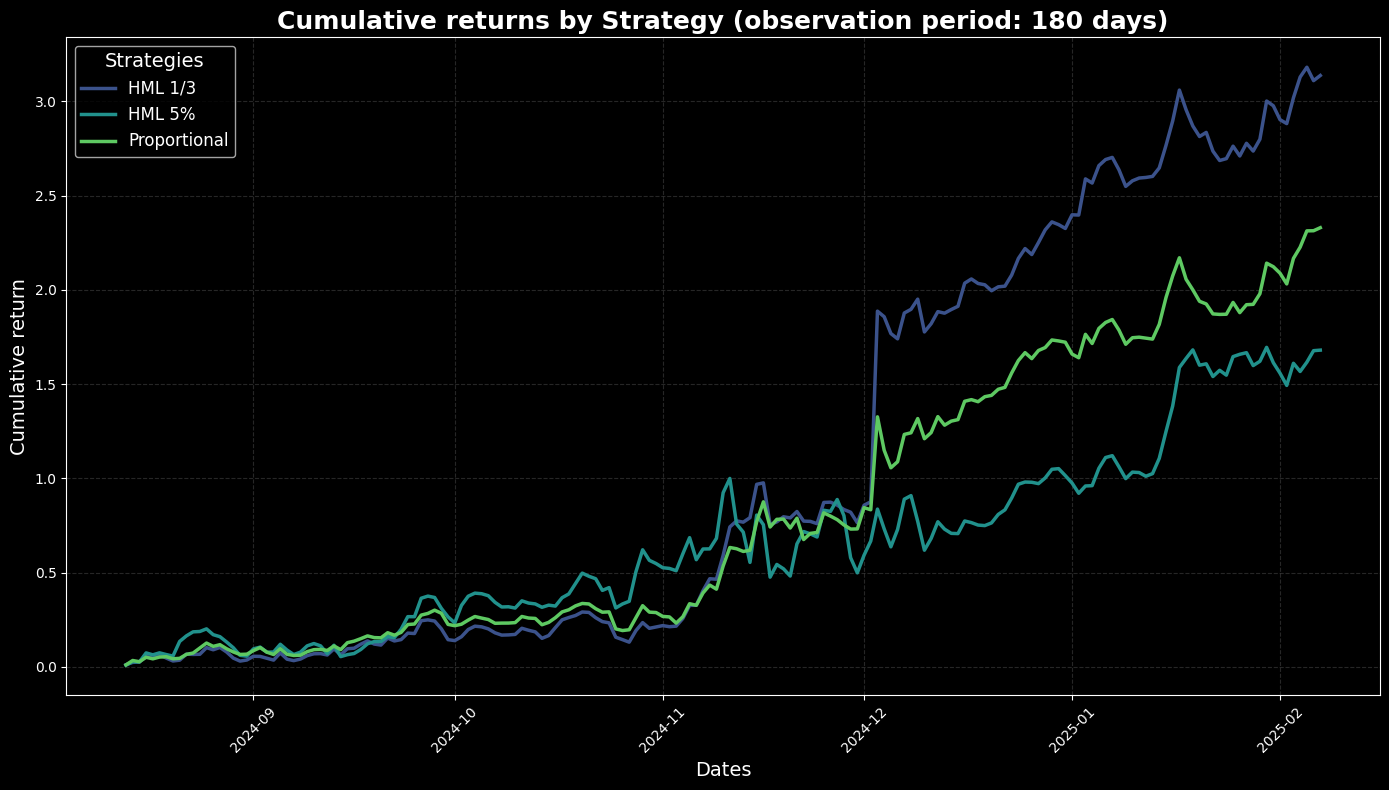

In [61]:
# Tracé des rendements cumulés
plot_cumulative_returns(results, dates) 

In [62]:
BASE_DIR = os.getcwd()  
SAVE_DIR = os.path.join(BASE_DIR, "..", "data", "raw")  

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

stats_file_path = os.path.join(SAVE_DIR, "portfolio_statistics.json")
returns_file_path = os.path.join(SAVE_DIR, "portfolio_returns.json")
graph_file_path = os.path.join(SAVE_DIR, "cumulative_returns.png")

# Sauvegarde des statistiques du portefeuille en JSON
stats_df.to_json(stats_file_path, orient="records", indent=4)
print(f"{os.path.basename(stats_file_path)} sauvegardé avec succès dans {SAVE_DIR} !")

# Sauvegarde des rendements cumulés en JSON
with open(returns_file_path, "w") as f:
    json.dump(results, f, indent=4)
print(f"{os.path.basename(returns_file_path)} sauvegardé avec succès dans {SAVE_DIR} !")

# Traçage des rendements cumulés et sauvegarde en PNG
GRAPH_PATH = graph_file_path
plot_cumulative_returns(results, dates, save_path=GRAPH_PATH)
print(f"Graphique sauvegardé avec succès : {GRAPH_PATH}")

portfolio_statistics.json sauvegardé avec succès dans c:\Users\kadas\Desktop\Mes_cours\FINANCE_QUAN\Projet_finance_quantitative\data_processing\..\data\raw !
portfolio_returns.json sauvegardé avec succès dans c:\Users\kadas\Desktop\Mes_cours\FINANCE_QUAN\Projet_finance_quantitative\data_processing\..\data\raw !
✅ Graphique sauvegardé avec succès : c:\Users\kadas\Desktop\Mes_cours\FINANCE_QUAN\Projet_finance_quantitative\data_processing\..\data\raw\cumulative_returns.png
Graphique sauvegardé avec succès : c:\Users\kadas\Desktop\Mes_cours\FINANCE_QUAN\Projet_finance_quantitative\data_processing\..\data\raw\cumulative_returns.png


In [63]:
print(f"📂 Dossier de sauvegarde : {SAVE_DIR}")

📂 Dossier de sauvegarde : c:\Users\kadas\Desktop\Mes_cours\FINANCE_QUAN\Projet_finance_quantitative\data_processing\..\data\raw
